
# Project 2: swarming behavior and correlated velocities

In this project you will explore the properties of the [Vicsek swarming model](https://en.wikipedia.org/wiki/Vicsek_model) and you will generalize it by adding rules to the interactions of the active particles in the system.

The model has an internal noise parameter ("$eta$" in the implementation below), and it is known that increasing $eta$ from $0$ to $1$ will lead the swarm to undergo a phase transition, i.e. a qualitative change of behavior, which in this case manifests itself as a passage from collective, ordered motion to random motion for the active particles. 

Referring to the concepts of polarization, correlation function, and correlation length defined in the article [Scale-free correlations in starling flocks](https://www.pnas.org/content/107/26/11865), answer the following questions:


(1) Estimate the value of $eta$ for which there is a phase transition in the Vicsek model, by using the polarization $\Phi$ of the system. Test your method for several values of size $N$ of the system, and several choices of initial random distributions of the active particles.


(2) Estimate the correlation function $C(r)$ of fluctuations of velocities within the Vicsek model, for multiple values of $eta$ and for $N \approx 10^3$. Estimate $\bar r$, the value of $r$ for which $C(r)$ becomes zero ($\bar r$ is an estimate of the correlation length of the swarm). 


(3) Research the literature to find other swarming and flocking models. On the basis of your literature review and your intuition, try to modify the Vicsek model so that you increase the average value of $\bar r$ for the swarm.  

N.B. all your answers should be in reference to the system in an "asymptotic" state when the initial random distribution of the positions and velocities of the active particles is no more significant to the dynamics.



This code template is taken from a blog post of [Francesco Turci](https://francescoturci.net/2020/06/19/minimal-vicsek-model-in-python/), a researcher in disordered systems. This specific Python implementation allows you to simulate far more active particles than it would be possible with a direct, naive implementation of the Vicsek model.

In [1]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

L = 32.0
rho = 3.0
N = int(rho*L**2)
print(" N",N)
 
r0 = 1.0
deltat = 1.0
factor = 0.5
v0 = r0/deltat*factor
iterations = 1000
eta = 0

pos = np.random.uniform(0,L,size=(N,2))
orient = np.random.uniform(-np.pi, np.pi,size=N)

#Sets initial pos and orient values in this cell so they cannot accidentally be altered in later versions
pos0 = pos
orient0 = orient

 N 3072


In [2]:
def Vicsek(pos, orient, eta):
    
    tree = cKDTree(pos,boxsize=[L,L])
    dist = tree.sparse_distance_matrix(tree, max_distance=r0,output_type='coo_matrix')
 
    data = np.exp(orient[dist.col]*1j)
    neigh = sparse.coo_matrix((data,(dist.row,dist.col)), shape=dist.get_shape())
    S = np.squeeze(np.asarray(neigh.tocsr().sum(axis=1)))
        
    orient = np.angle(S)+eta*np.random.uniform(-np.pi, np.pi, size=N)
        
    cos, sin= np.cos(orient), np.sin(orient)
    pos[:,0] += cos*v0
    pos[:,1] += sin*v0

    pos[pos>L] -= L
    pos[pos<0] += L
    
    return pos, orient

In [3]:
def Polarization(orient, N):
    v = (np.cos(orient), np.sin(orient))
    v_sum = np.sum(v, axis=1)
    v_mod = v_sum * (1/N)
    phi = np.linalg.norm(v_mod)
    return phi

<IPython.core.display.Javascript object>


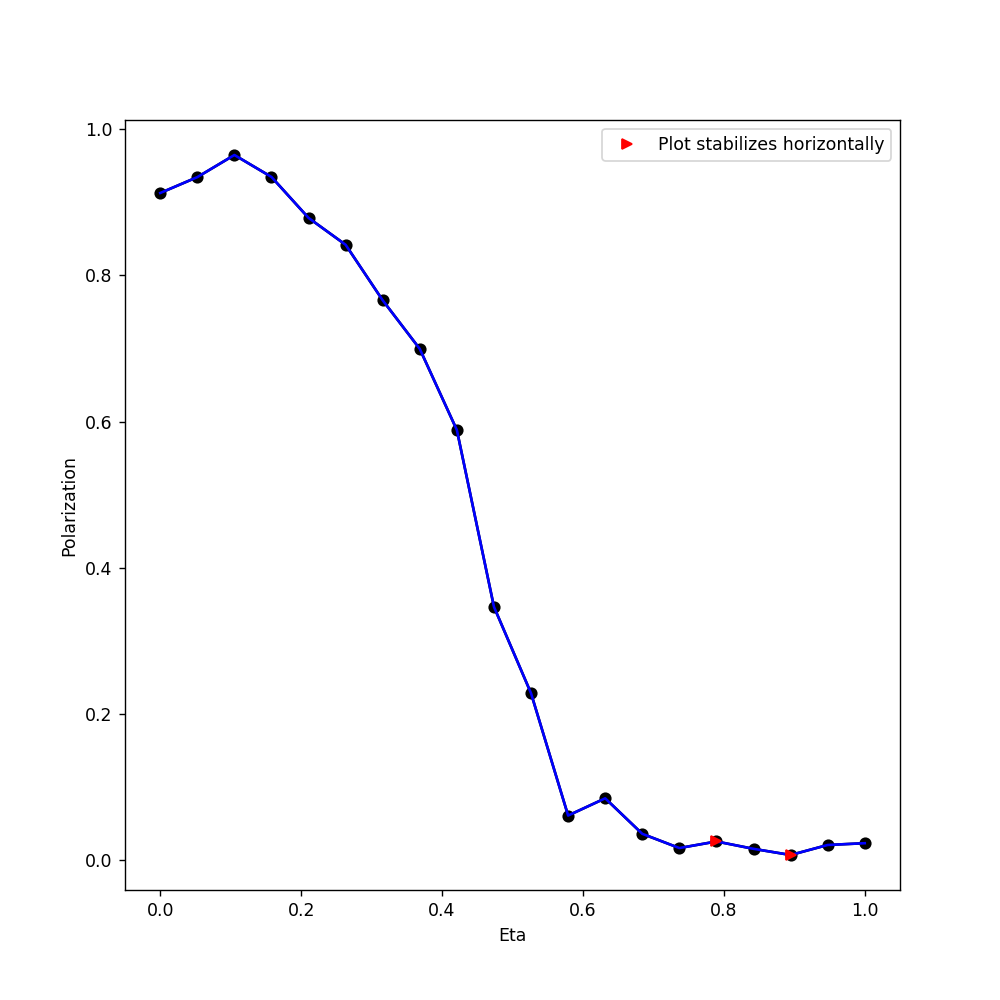

In [4]:
times = 20
count = 0
eta_values = np.linspace(0, 1, times)

polarization_points = np.zeros(times)

fig1, ax1 = plt.subplots(1, 1, figsize=(8, 8))

for eta in eta_values:
    pos = pos0
    orient = orient0
    for i in range(iterations):
        pos, orient = Vicsek(pos, orient, eta)
    polarization_points[count] = Polarization(orient, N)
    count += 1

plt.xlabel("Eta")
plt.ylabel("Polarization")
ax1.plot(eta_values, polarization_points, "ro-", color = "black")

In [5]:
#Citation: https://stackoverflow.com/questions/47342447/find-locations-on-a-curve-where-the-slope-changes
#Citation: https://stackoverflow.com/questions/10062954/valueerror-the-truth-value-of-an-array-with-more-than-one-element-is-ambiguous

#Define masking function for phase shift
def masks(vec):
    d = np.diff(vec)
    # Mask of locations where graph stabilizes horizontally (slope difference is not greater or less than 0.05)
    to_mask = ((d[:-1] <= 0.01) & (d[:-1] >= -0.01))

    return to_mask

to_horiz_mask = masks(polarization_points)

#Define function to apply defined mask function to all points on the graph
def apply_mask(mask, x, y):
    return x[1:-1][mask], y[1:-1][mask]

to_horiz_eta, to_horiz_phi = apply_mask(to_horiz_mask, eta_values, polarization_points)

#Generate plot with masked points layered on top
plt.plot(eta_values, polarization_points, 'b-')
plt.plot(to_horiz_eta, to_horiz_phi, 'r>', label='Plot stabilizes horizontally')
plt.legend()
plt.show()
#From this plot we can clearly see where the "phase shift" occurs as discussed in class

In [6]:
#Example Code for testing different initial random distributions:

L = 32.0
rho = 3.0
N = int(rho*L**2)

pos = np.random.randint(0,L,size=(N,2))
orient = np.random.randint(-np.pi, np.pi,size=N)

#More random distributions: https://numpy.org/doc/1.16/reference/routines.random.html

In [7]:
#Example Code for testing different N values:

L = 100.0
rho = 10.0
N = int(rho*L**2)

pos = np.random.uniform(0,L,size=(N,2))
orient = np.random.uniform(-np.pi, np.pi,size=N)

In [8]:
print(polarization_points)

[0.91284018 0.93454611 0.96483616 0.93480706 0.87874812 0.84199161
 0.76597501 0.69944642 0.58843443 0.3465765  0.22826081 0.06096448
 0.08452287 0.03593059 0.01647633 0.02548777 0.01538505 0.00696166
 0.02067544 0.02310335]


In [ ]:
def Correlation(r):
    global pos, orient, N, ui, uj
    sumtop = 0
    sumbot = 0
    delta_r = 0.01
    
    for i in range(N):
        for j in range(N):
            r_ij = ((pos[i]**2)-pos[j]**2)**0.5
            if r_ij < delta_r:
                sumtop += np.dot(ui, uj)
                sumbot += 1
    
    Cr = sumtop / sumbot
    
    return Cr

In [ ]:
ui = vi - v_mean
uj = 

ui = []
uj = []









r = 1










